In [1]:
import netket as nk
import netket.experimental as nkx
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc
from netket.models.slater import Slater2nd
from scipy.sparse.linalg import eigsh
import numpy as np
import scipy.sparse.linalg
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt

import sys, os
sys.path.append('/Users/wttai/Documents/Jupyter/machine_learning/common_lib')
sys.path.append('/home1/wttai/machine_learning/common_lib')
from models import get_qwz_graph, get_debug_Ham
from networks import *
from helper import get_ed_data

In [4]:
L = 2
Lx = L
Ly = L
N = Lx * Ly

graph, hi = get_qwz_graph(L = Lx, L2 = Ly, pbc = False, N = N)

m = 5.0
t = 1.0
U = 1.0
s = 0
p = 1
learning_rate = 0.01
diag_shift = 0.01

H = get_debug_Ham(hi, graph, m = m, t = t, U = U)

# Exact diagonalization

evals, evecs = get_ed_data(H, k = 6)
E_gs = evals[0]

Exact ground state energy: -20.727694291809936


In [16]:
s, p = 1, -1
def corr_func(i):
    return cdag(hi, i, s) * c(hi, 0, s) + cdag(hi, i, p) * c(hi, 0, p)

In [17]:
corrs = {}
for i in range(N):
    corrs[f"cdag{i}c0"] = corr_func(i)

# Slater Determinant

In [18]:
n_iter = 300
# Create the Slater determinant model
model = Slater2nd(hi, generalized=True)#LogSlaterDeterminant(hi)

# Define the Metropolis-Hastings sampler
sa = nk.sampler.ExactSampler(hi) 
#sa = nk.sampler.MetropolisLocal(hi)
#sa = nk.sampler.MetropolisExchange(hi, graph=graph)

vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=learning_rate)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=diag_shift)

# Create the VMC (Variational Monte Carlo) driver
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
slater_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=n_iter, out=slater_log, obs = corrs)

/home1/wttai/.conda/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:252: UserWarning: An exact sampler does not need to discard samples. Setting n_discard_per_chain to 0.
  self.n_discard_per_chain = n_discard_per_chain


  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['cdag0c0', 'cdag1c0', 'cdag2c0', 'cdag3c0', 'Energy'],)

In [19]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -8.8921-0.0000j ± 0.0060 [σ²=0.1885]
Relative error   : 0.0019028482384321678


In [20]:
# Create a Neural Jastrow Slater wave function 
model = LogNeuralJastrowSlater(hi, hidden_units=N)

# Define a Metropolis exchange sampler
sa = nk.sampler.ExactSampler(hi) 
#sa = nk.sampler.MetropolisLocal(hi)
#sa = nk.sampler.MetropolisExchange(hi, graph=graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=learning_rate)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=diag_shift)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
nj_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=nj_log)

/home1/wttai/.conda/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:252: UserWarning: An exact sampler does not need to discard samples. Setting n_discard_per_chain to 0.
  self.n_discard_per_chain = n_discard_per_chain


  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['Energy'],)

In [21]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -8.9059+0.0000j ± 0.0037 [σ²=0.0581]
Relative error   : 0.00035568842286667505


In [22]:
# Create a neural backflow wave function
model = LogNeuralBackflow(hi, hidden_units=N)

# Define a Metropolis exchange sampler
#sa = nk.sampler.MetropolisExchange(hi, graph=graph)
#sa = nk.sampler.MetropolisLocal(hi)
sa = nk.sampler.ExactSampler(hi) 

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=diag_shift)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
bf_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=bf_log)

/home1/wttai/.conda/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:252: UserWarning: An exact sampler does not need to discard samples. Setting n_discard_per_chain to 0.
  self.n_discard_per_chain = n_discard_per_chain


  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['Energy'],)

In [23]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -8.9007+0.0000j ± 0.0015 [σ²=0.0097]
Relative error   : 0.0009407274642455184


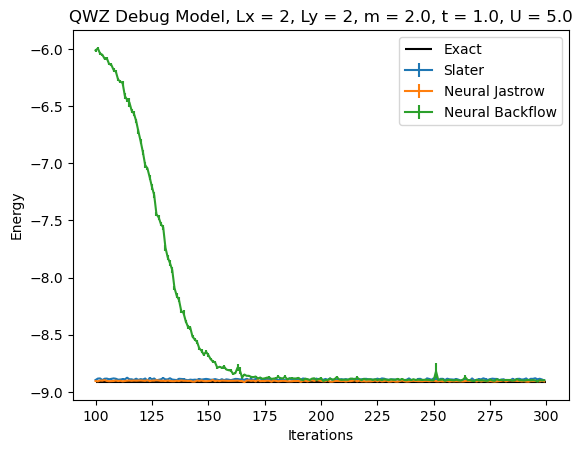

In [25]:
logged_data = (slater_log.data,nj_log.data,bf_log.data)
labels = ("Slater","Neural Jastrow","Neural Backflow")

from matplotlib import pyplot as plt

start = 100

end = 300

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters[start:end], data["Energy"].Mean.real[start:end], yerr=data["Energy"].Sigma[start:end],label=label)

plt.hlines([E_gs], xmin=start, xmax=end, color='black', label="Exact")
plt.title(f"QWZ Debug Model, Lx = {Lx}, Ly = {Ly}, m = {m}, t = {t}, U = {U}")

plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()

/tmp/ipykernel_15006/124353240.py:11: RuntimeWarning: invalid value encountered in log
  plt.errorbar(data["Energy"].iters[start:end], np.log((data["Energy"].Mean.real[start:end]-E_gs)/abs(E_gs)),label=label)


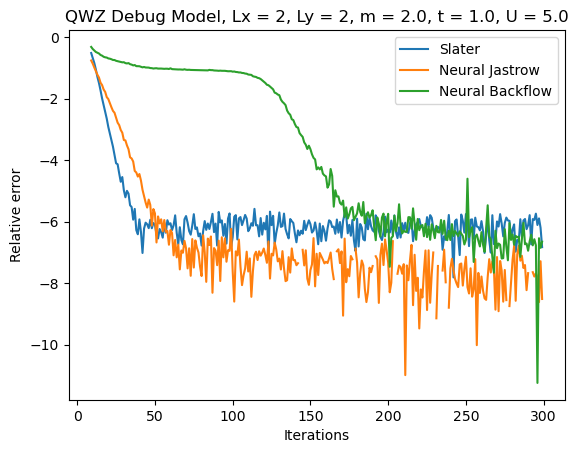

In [37]:
logged_data = (slater_log.data,nj_log.data,bf_log.data)
labels = ("Slater","Neural Jastrow","Neural Backflow")

from matplotlib import pyplot as plt

start = 9

end = 300

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters[start:end], np.log((data["Energy"].Mean.real[start:end]-E_gs)/abs(E_gs)),label=label)
    
plt.title(f"QWZ Debug Model, Lx = {Lx}, Ly = {Ly}, m = {m}, t = {t}, U = {U}")

plt.xlabel('Iterations')
plt.ylabel('Relative error')
plt.legend()